In [111]:
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'svg'
import pickle
from rfpimp import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import librosa
from sklearn.datasets import make_classification
from sklearn.model_selection import GroupKFold

In [277]:
%%capture
!pip install librosa

In [258]:
with open('raw_df.pkl', 'rb') as f:
    audio_df = pickle.load(f)

In [259]:
audio_df.head()

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,...,chroma_std7,chroma_std8,chroma_std9,chroma_std10,chroma_std11,chroma_std12,rolloff_mean,rolloff_std,label,fold
0,-131.953600,100.331800,-136.209613,59.544095,-41.002218,18.666155,-29.881801,7.720259,-13.521617,-2.472400,...,0.082744,0.086488,0.103079,0.091772,0.083112,0.087800,4190.474661,789.164506,6,fold1
1,-212.984794,113.986069,-27.193258,22.607542,0.675223,4.756774,15.624546,15.003598,12.439341,11.358548,...,0.235415,0.252663,0.193080,0.210450,0.206592,0.201269,3779.575026,698.880879,2,fold1
2,-58.958201,87.640273,-70.350945,-2.818272,-22.161617,-7.152818,-19.660093,-5.150989,-23.104785,-5.124065,...,0.122456,0.133950,0.129118,0.114089,0.124617,0.122561,4129.396225,773.733583,4,fold1
3,-365.765009,61.840576,8.505344,33.080384,6.873962,-5.327185,-3.849906,-5.238709,-4.314379,-4.959619,...,0.244525,0.233069,0.224638,0.231544,0.270749,0.263057,5021.219348,1082.168871,2,fold1
4,-84.870940,116.204518,-24.585843,9.107674,6.315533,3.426022,4.600642,4.316528,-0.700944,11.300272,...,0.112480,0.111136,0.099302,0.101390,0.095279,0.106619,3822.828136,411.186238,7,fold1


In [260]:
audio_df.label.value_counts()

7    1000
5    1000
4    1000
3    1000
2    1000
9    1000
0    1000
8     929
1     429
6     374
Name: label, dtype: int64

In [261]:
audio_df.fold.value_counts()

fold4     990
fold5     936
fold3     925
fold2     888
fold1     873
fold7     838
fold10    837
fold6     823
fold9     816
fold8     806
Name: fold, dtype: int64

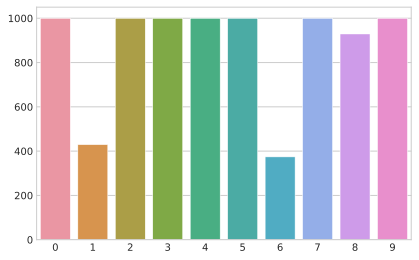

In [278]:
unique = np.unique(audio_df.label, return_counts=True)
sns.barplot(unique[0],unique[1]);

In [79]:
librosa_load0, librosa_sampling_rate0 = librosa.load('../50901-0-1-0.wav', mono=True)
librosa_load1, librosa_sampling_rate1 = librosa.load('../19026-1-0-0.wav', mono=True)
librosa_load2, librosa_sampling_rate2 = librosa.load('../15564-2-0-2.wav', mono=True)
librosa_load3, librosa_sampling_rate3 = librosa.load('../7383-3-0-0.wav', mono=True)
librosa_load4, librosa_sampling_rate4 = librosa.load('../14113-4-0-0.wav', mono=True)
librosa_load5, librosa_sampling_rate5 = librosa.load('../17592-5-0-0.wav', mono=True)
librosa_load6, librosa_sampling_rate6 = librosa.load('../7061-6-0-0.wav', mono=True)
librosa_load7, librosa_sampling_rate7 = librosa.load('../98223-7-5-0.wav', mono=True)
librosa_load8, librosa_sampling_rate8 = librosa.load('../30823-8-0-0.wav', mono=True)
librosa_load9, librosa_sampling_rate9 = librosa.load('../21684-9-0-7.wav', mono=True)

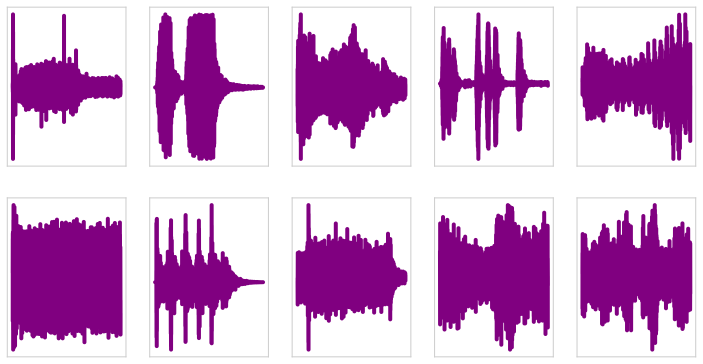

In [109]:
plt.figure(figsize=(11,6))

plt.subplot(2, 5, 1)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load0, color='purple')

plt.subplot(2, 5, 2)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load1, color='purple')

plt.subplot(2, 5, 3)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load2, color='purple')

plt.subplot(2, 5, 4)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load3, color='purple')

plt.subplot(2, 5, 5)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load4, color='purple')

plt.subplot(2, 5, 6)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load5, color='purple')

plt.subplot(2, 5, 7)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load6, color='purple')

plt.subplot(2, 5, 8)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load7, color='purple')

plt.subplot(2, 5, 9)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load8, color='purple')

plt.subplot(2, 5, 10)
plt.yticks([])
plt.xticks([])
plt.plot(librosa_load9, color='purple');

In [243]:
groups = audio_df.loc[:, 'fold']
y = audio_df.loc[:, 'label']
X = audio_df.iloc[:, 0:-2]

**A Note on Train/Test**
The author's of this data set mention that they extracted the initial audio clips from different longer recordings. Thus, it's possible that if you naively shuffled, you could have a clip in the train and a different clip in the test that came from the same original recording. To combat this, they created 10 different folds corresponding to the 10 different original long recordings that were cut into 8,732 pieces. They suggest running 10-fold CV as the main (averaged) metric using the pre-determined folds, which will combat the problem above.

HOWEVER - I'd still like to pursue a modified standard train/validate(in CV loop)/test approach. To do this I propose the following:
1. Create 10 different splits: 1 fold for holdout, 9 folds for training/validation
2. Train 9-fold CV on the remaining data resulting from holding out 1
3. Report average test score. This way, the scored-test data was truly never seen in hyperparameter tuning phase.

Note I did run some initial models using their proposed 10-fold schema without doing this, so I have that here to see if any of this ends up making much of a difference:

Results for non-augmented data set from initial pull (i.e. no pitch-shifting) with StandardScaler on 10-fold CV of pre-determined splits:
1. Logistic Mean accuracy: 0.643 +- 0.036
2. Gaussian NB Mean accuracy: 0.490 +- 0.033
3. SVM (RBF) Mean accuracy: 0.713 +- 0.022

Poorer performance: MinMax scaler, other types of SVM kernels, PCA.

In [262]:
y_te1 = y.iloc[0:873]
y_tr1 = y.iloc[873:]
X_te1 = X.iloc[0:873, :]
X_tr1 = X.iloc[873:, :]
groups_1 = groups.drop(groups.index[0:873])
y_te1, y_tr1, X_te1, X_tr1 = np.array(y_te1), np.array(y_tr1), np.array(X_te1), np.array(X_tr1)

In [263]:
y_te2 = y.iloc[873:1761]
y_tr2 = pd.concat([y.iloc[0:873], y.iloc[1761:]])
X_te2 = X.iloc[873:1761, :]
X_tr2 = X.drop(X.index[873:1761])
groups_2 = groups.drop(groups.index[873:1761])
y_te2, y_tr2, X_te2, X_tr2 = np.array(y_te2), np.array(y_tr2), np.array(X_te2), np.array(X_tr2)

In [264]:
y_te3 = y.iloc[1761:2686]
y_tr3 = pd.concat([y.iloc[0:1761], y.iloc[2686:]])
X_te3 = X.iloc[1761:2686, :]
X_tr3 = X.drop(X.index[1761:2686])
groups_3 = groups.drop(groups.index[1761:2686])
y_te3, y_tr3, X_te3, X_tr3 = np.array(y_te3), np.array(y_tr3), np.array(X_te3), np.array(X_tr3)

In [265]:
y_te4 = y.iloc[3676:4612]
y_tr4 = pd.concat([y.iloc[0:3676], y.iloc[4612:]])
X_te4 = X.iloc[3676:4612, :]
X_tr4 = X.drop(X.index[3676:4612])
groups_4 = groups.drop(groups.index[3676:4612])
y_te4, y_tr4, X_te4, X_tr4 = np.array(y_te4), np.array(y_tr4), np.array(X_te4), np.array(X_tr4)

In [266]:
y_te5 = y.iloc[4612:5434]
y_tr5 = pd.concat([y.iloc[0:4612], y.iloc[5434:]])
X_te5 = X.iloc[4612:5434, :]
X_tr5 = X.drop(X.index[4612:5434])
groups_5 = groups.drop(groups.index[4612:5434])
y_te5, y_tr5, X_te5, X_tr5 = np.array(y_te5), np.array(y_tr5), np.array(X_te5), np.array(X_tr5)

In [267]:
y_te6 = y.iloc[5434:6273]
y_tr6 = pd.concat([y.iloc[0:5434], y.iloc[6273:]])
X_te6 = X.iloc[5434:6273, :]
X_tr6 = X.drop(X.index[5434:6273])
groups_6 = groups.drop(groups.index[5434:6273])
y_te6, y_tr6, X_te6, X_tr6 = np.array(y_te6), np.array(y_tr6), np.array(X_te6), np.array(X_tr6)

In [268]:
y_te7 = y.iloc[6273:7079]
y_tr7 = pd.concat([y.iloc[0:6273], y.iloc[7079:]])
X_te7 = X.iloc[6273:7079, :]
X_tr7 = X.drop(X.index[6273:7079])
groups_7 = groups.drop(groups.index[6273:7079])
y_te7, y_tr7, X_te7, X_tr7 = np.array(y_te7), np.array(y_tr7), np.array(X_te7), np.array(X_tr7)

In [269]:
y_te8 = y.iloc[7079:7895]
y_tr8 = pd.concat([y.iloc[0:7079], y.iloc[7895:]])
X_te8 = X.iloc[7079:7895, :]
X_tr8 = X.drop(X.index[7079:7895])
groups_8 = groups.drop(groups.index[7079:7895])
y_te8, y_tr8, X_te8, X_tr8 = np.array(y_te8), np.array(y_tr8), np.array(X_te8), np.array(X_tr8)

In [270]:
y_te9 = y.iloc[7895:8732]
y_tr9 = pd.concat([y.iloc[0:7895], y.iloc[8732:]])
X_te9 = X.iloc[7895:8732, :]
X_tr9 = X.drop(X.index[7895:8732])
groups_9 = groups.drop(groups.index[7895:8732])
y_te9, y_tr9, X_te9, X_tr9 = np.array(y_te9), np.array(y_tr9), np.array(X_te9), np.array(X_tr9)

In [271]:
group_list = [groups_1, groups_2, groups_3, groups_4, groups_5,
             groups_6, groups_7, groups_8, groups_9]

In [272]:
X_tr_list = [X_tr1, X_tr2, X_tr3, X_tr4, X_tr5, X_tr6, X_tr7, X_tr8, X_tr9]

In [273]:
y_tr_list = [y_tr1, y_tr2, y_tr3, y_tr4, y_tr5, y_tr6, y_tr7, y_tr8, y_tr9]

In [274]:
X_te_list = [X_te1, X_te2, X_te3, X_te4, X_te5, X_te6, X_te7, X_te8, X_te9]
y_te_list = [y_te1, y_te2, y_te3, y_te4, y_te5, y_te6, y_te7, y_te8, y_te9]

## Hyperparameter Tuning - Validation CV

In [320]:
%%capture
logr_f1, gnb_f1, svm_f1, rfc_f1 = [], [], [], []
logr_cv_mean, gnb_cv_mean, svm_cv_mean, rfc_cv_mean = [], [], [], []
logr_cv_std, gnb_cv_std, svm_cv_std, rfc_cv_std = [], [], [], []

for i in range(0,9):
    gkf = GroupKFold(n_splits=9)
    for train, val in gkf.split(X_tr_list[i], y_tr_list[i], groups=group_list[i]):
        X_tr, y_tr = X_tr_list[i][train], y_tr_list[i][train]
        X_val, y_val = X_tr_list[i][val], y_tr_list[i][val]

        scaler = StandardScaler()
        X_tr_scale = scaler.fit_transform(X_tr)
        X_val_scale = scaler.transform(X_val)

        logr = LogisticRegression(C=1000)
        logr.fit(X_tr_scale, y_tr)
        y_pred_logr = logr.predict(X_val_scale)
        logr_f1.append(f1_score(y_val, y_pred_logr, average='macro'))
        
        svm_rbf = SVC(kernel="rbf", cache_size=1000, gamma=.01)
        svm_rbf.fit(X_tr_scale, y_tr)
        y_pred_svm = svm_rbf.predict(X_val_scale)
        svm_f1.append(f1_score(y_val, y_pred_svm, average='macro'))

        rfc = RandomForestClassifier(n_estimators=50)
        rfc.fit(X_tr_scale, y_tr)
        y_pred_rfc = rfc.predict(X_val_scale)
        rfc_f1.append(f1_score(y_val, y_pred_rfc, average='macro'))
    
        logr_cv_mean.append(np.mean(logr_f1))
        logr_cv_std.append(np.std(logr_f1))
        svm_cv_mean.append(np.mean(svm_f1))
        svm_cv_std.append(np.std(svm_f1))
        rfc_cv_mean.append(np.mean(rfc_f1))
        rfc_cv_std.append(np.std(rfc_f1))

In [321]:
print(f'Logistic Train accuracy: {np.mean(logr_cv_mean):.3f} +- {np.std(logr_cv_std):.3f}')
print(f'SVM Train accuracy: {np.mean(svm_cv_mean):.3f} +- {np.std(svm_cv_std):.3f}')
print(f'Random Forest Train accuracy: {np.mean(rfc_cv_mean):.3f} +- {np.std(rfc_cv_std):.3f}')

Logistic Train accuracy: 0.655 +- 0.006
SVM Train accuracy: 0.723 +- 0.003
Random Forest Train accuracy: 0.687 +- 0.006


## Grid Search for SVM Gamma
Use winner in loop above

In [314]:
%%capture
logr_f1, gnb_f1, svm_f1, rfc_f1 = [], [], [], []
from sklearn.model_selection import GridSearchCV
best = []
final_params = []
for i in range(0,9):
    gkf = GroupKFold(n_splits=9)
    for train, val in gkf.split(X_tr_list[i], y_tr_list[i], groups=group_list[i]):
        X_tr, y_tr = X_tr_list[i][train], y_tr_list[i][train]

        scaler = StandardScaler()
        X_tr_scale = scaler.fit_transform(X_tr)
        
        gamma_list = [0.005, .0001, 0.01, 0.1, 1]
        param_grid = {'gamma' : gamma_list}
        grid_search = GridSearchCV(SVC(kernel='rbf', cache_size=1000), param_grid, cv=3)
        grid_search.fit(X_tr_scale, y_tr)
        best.append(grid_search.best_params_)
        break

In [319]:
best #note this is basically the default value of what gamma would have been given num_features, default=.015

[{'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01},
 {'gamma': 0.01}]

## Final Test Loop

In [322]:
%%capture

svm_test_f1 = []

for i in range(0,9):
    X_tr, y_tr = X_tr_list[i], y_tr_list[i]
    X_te, y_te = X_te_list[i], y_te_list[i]
    
    scaler = StandardScaler()
    X_tr_scale = scaler.fit_transform(X_tr)
    X_te_scale = scaler.transform(X_te)

    svm_rbf = SVC(kernel="rbf", cache_size=1000, gamma=.01)
    svm_rbf.fit(X_tr_scale, y_tr)
    test_pred_svm = svm_rbf.predict(X_te_scale)
    svm_test_f1.append(f1_score(y_te, test_pred_svm, average='macro'))

In [323]:
print(f'SVM Test f1: {np.mean(svm_test_f1):.3f} +- {np.std(svm_test_f1):.3f}')

SVM Test f1: 0.733 +- 0.020
